# Session-Based Recommendation

## - 목차   

1. 데이터 불러오기   
2. 데이터 전처리    
3. Data Pipeline   
4. 모델링   
5. 결과 개선 시도   

- 프로젝트 정리

## 1. 데이터 불러오기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings

data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  del sys.path[0]


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있기 때문에 이번에는 UserID가 SessionID 역할을 해야 함.
- Rating 정보가 포함되어있어 이 Rating 데이터를 어떻게 할 것인지 고민해야 함.
- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어있음. 이는 보기 편하게  datetime 형식으로 바꿀 것.

In [2]:
#Time 데이터(Second)를 Datetime으로 바꾸기

from datetime import date
start = '1970-01-01 00:00:00.000000'
start = dt.datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f')
print(start)

1970-01-01 00:00:00


In [3]:
from datetime import timedelta

date = []
for delta in data['Time'] :
    date.append(start + timedelta(seconds = delta))
    
data['Time'] = date

data['Time']

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Time, Length: 1000209, dtype: datetime64[ns]

In [4]:
#Time을 datetime으로 바꾼 data
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [5]:
#data를 UserId와 Time으로 오름차순 정렬
data.sort_values(['UserId', 'Time'], inplace= True)

data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [6]:
#UesrId, ItemId, Time 개수 확인
data['UserId'].nunique(), data['ItemId'].nunique(), data['Time'].nunique()

(6040, 3706, 458455)

## 2. 데이터 전처리

### - Session Length
- SessionID 대신 UserID 항목이 들어갔기 때문에 UserID가 SessionID 역할을 해야한다는 노드의 글을 보고 UserId로 session 길이를 구해봤다.

In [7]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [8]:
print('session_median:', session_length.median())
print('session_mean:', session_length.mean())
print('session_min:', session_length.min())
print('session_max:', session_length.max())

session_median: 96.0
session_mean: 165.5975165562914
session_min: 20
session_max: 2314


In [9]:
session_length.quantile(0.999)

1343.181000000005

- session_length란 같은 SessionId를 공유하는 데이터 row의 개수를 의미하며 해당 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지(몇개의 영화 평점을 남겼는지)를 의미함.
- UserId로 session 길이를 구한 결과를 봤을 때 제대로 session이 나누어졌다고 보기 힘들다고 판단했음. 
- 때문에 SessionId가 없기 때문에 어떤 기준으로 session을 나누고, session 단위로 어떻게 해석할지 판단해야 했음.

### - SessionId
- UserId와 Time 모두 고려하여 Session을 정의해야 하기 때문에 groupby를 이용하여 UserId와 Time을 기준으로 새로운 데이터 프레임을 생성 후 기존 데이터 프레임과 합치는 방법을 생각함.

In [10]:
#groupby를 이용하여 UserId와 Time을 기준으로 새로운 데이터 프레임을 생성
data_gr = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
data_gr.reset_index(inplace = True)
data_gr

,index,UserId,Time,ItemId
0,0,1,2000-12-31 22:00:19,1
1,1,1,2000-12-31 22:00:55,3
2,2,1,2000-12-31 22:01:43,1
3,3,1,2000-12-31 22:02:52,1
4,4,1,2000-12-31 22:04:35,1
...,...,...,...,...
471158,471158,6040,2001-08-10 14:39:58,1
471159,471159,6040,2001-08-10 14:40:29,1
471160,471160,6040,2001-08-10 14:41:04,2
471161,471161,6040,2001-08-10 14:41:26,1


In [11]:
#새로운 데이터 프레임과 기존 데이터 프레임을 UserId와 Time을 기준으로 합침.
data = pd.merge(data, data_gr, on = ['UserId', 'Time'])
data

,UserId,ItemId_x,Rating,Time,index,ItemId_y
0,1,3186,4,2000-12-31 22:00:19,0,1
1,1,1270,5,2000-12-31 22:00:55,1,3
2,1,1721,4,2000-12-31 22:00:55,1,3
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,1
...,...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159,1
1000205,6040,1921,4,2001-08-10 14:41:04,471160,2
1000206,6040,1784,3,2001-08-10 14:41:04,471160,2
1000207,6040,161,3,2001-08-10 14:41:26,471161,1


- UserId와 Time을 기준으로 합쳤기 때문에 ItemId_y 칼럼은 불필요한 데이터가 됨.
- 또, UserId와 Time이 짝을 이루어 하나의 Session이 됨.
- 새롭게 생긴 index 칼럼이 여기선 SessionId가 되는 것.


In [12]:
#불필요한 칼럼 삭제
data.drop(columns = 'ItemId_y', inplace = True)

#칼럼 명 수정
data.rename(columns = {'ItemId_x' : 'ItemId'}, inplace = True)
data.rename(columns = {'index' : 'SessionId'}, inplace = True)

data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


### - New Session Length

In [13]:
#각 세션이 몇 개의 클릭 데이터를 갖는지
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [14]:
print('session_median:', session_length.median())
print('session_mean:', session_length.mean())
print('session_min:', session_length.min())
print('session_max:', session_length.max())

session_median: 2.0
session_mean: 2.1228513274599234
session_min: 1
session_max: 30


- 한 세션 당 평균 약 2개의 영화를 평가했음.
- 한 세션에서 최대 30개의 영화를 평가함.
  - 한 UserId가 동시간에 30개의 영화를 평가한 것은 제대로 된 평가라고 생각하지 않아 이 세션을 이상치로 판단.

In [15]:
session_length.quantile(0.999)

10.0

- 전체 세션의 99.9%가 10개 이하의 평가를 남김.

In [16]:
#max에서 30인 값이 나온 것에 대해 자세히 볼 것 .
long_session = session_length[session_length==30].index[0]
display(data[data['SessionId']==long_session])
data[data['SessionId']==long_session].shape

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,2000-11-29 20:06:42,55117
112348,731,1455,3,2000-11-29 20:06:42,55117
112349,731,1639,5,2000-11-29 20:06:42,55117
112350,731,3244,4,2000-11-29 20:06:42,55117
112351,731,1656,2,2000-11-29 20:06:42,55117
112352,731,3426,4,2000-11-29 20:06:42,55117
112353,731,1829,2,2000-11-29 20:06:42,55117
112354,731,2675,4,2000-11-29 20:06:42,55117
112355,731,802,3,2000-11-29 20:06:42,55117
112356,731,803,5,2000-11-29 20:06:42,55117


(30, 5)

In [17]:
#한 UserId가 동시간에 30개의 영화를 평가한 것은 제대로 된 평가라고 생각하지 않아 이 세션을 이상치로 판단.

#이상치 제거
data = data.loc[data['SessionId'] != long_session]

data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


In [18]:
#세션길이 시각화

#세션길이 기준 하위 99.9%까지 분포 누적합
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

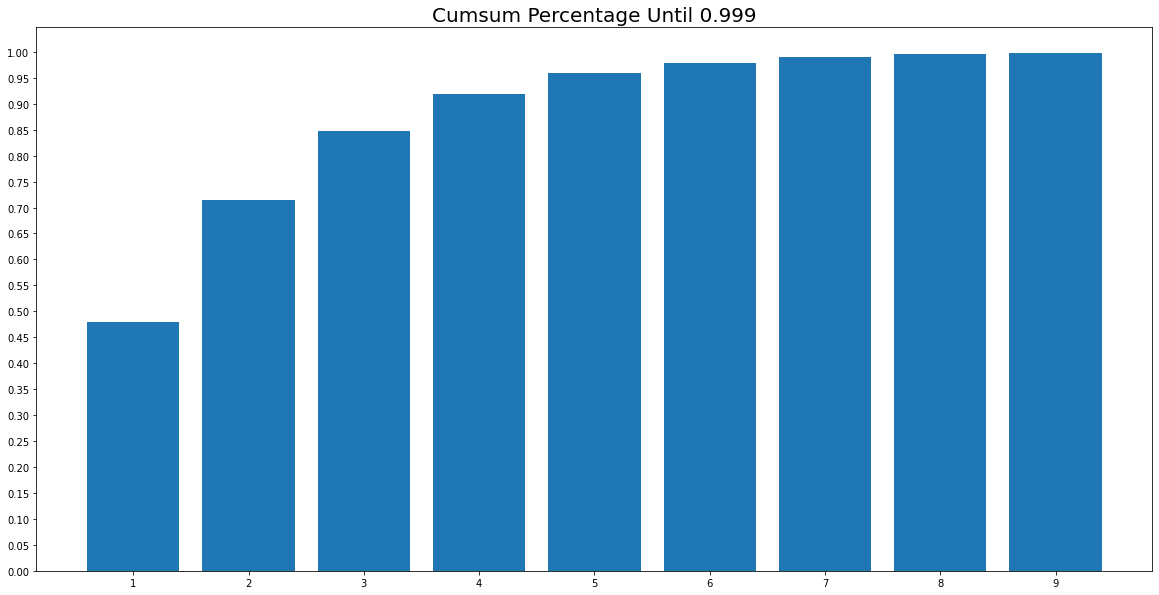

In [19]:
import matplotlib.pyplot as plt

#세션길이 기준 하위 99.9%까지 분포 누적합을 시각화
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999)
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### - Sesseion Time

In [20]:
#데이터가 발생한 시간
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [21]:
#time_counts = data['Time'].value_counts()
#time_counts

In [22]:
#time_counts.plot(kind='barh',title='Time counter')
#plt.show()

In [23]:
#2002년 데이터
time1_counts = data[data['Time'] >= dt.datetime(2002,1,1)]
time1_counts

,UserId,ItemId,Rating,Time,SessionId
5331,36,1292,5,2002-02-03 03:40:35,2789
5332,36,7,4,2002-02-03 03:41:37,2790
5333,36,1387,5,2002-03-12 03:46:59,2791
5334,36,1201,4,2002-03-12 03:46:59,2791
5335,36,1291,5,2002-03-12 03:47:16,2792
...,...,...,...,...,...
994106,6002,2013,4,2002-02-24 04:24:39,468893
994107,6002,2520,4,2002-02-24 04:24:40,468894
994108,6002,1387,5,2002-02-24 04:25:20,468895
994109,6002,1927,4,2002-02-24 04:25:58,468896


In [24]:
#2001년 ~ 2002년 데이터
time2_counts = data[data['Time'] >= dt.datetime(2001,1,1)]
time2_counts

,UserId,ItemId,Rating,Time,SessionId
40,1,1545,4,2001-01-06 23:35:39,28
41,1,527,5,2001-01-06 23:36:35,29
42,1,595,5,2001-01-06 23:37:48,30
43,1,2687,3,2001-01-06 23:37:48,30
44,1,745,3,2001-01-06 23:37:48,30
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


In [25]:
#2001년 데이터
time2_counts = time2_counts[time2_counts['Time'] < dt.datetime(2002,1,1)]
time2_counts

,UserId,ItemId,Rating,Time,SessionId
40,1,1545,4,2001-01-06 23:35:39,28
41,1,527,5,2001-01-06 23:36:35,29
42,1,595,5,2001-01-06 23:37:48,30
43,1,2687,3,2001-01-06 23:37:48,30
44,1,745,3,2001-01-06 23:37:48,30
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


In [26]:
#2000년 데이터
time3_counts = data[data['Time'] < dt.datetime(2001,1,1)]
time3_counts

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000181,6040,535,4,2000-07-28 23:58:54,471139
1000182,6040,495,2,2000-07-28 23:59:42,471140
1000183,6040,3751,4,2000-07-28 23:59:42,471140
1000184,6040,1077,5,2000-07-28 23:59:59,471141


- 2000년이 가장 많고 2001년, 2002년으로 갈 수록 줄어드는 것을 볼 수 있음.
- 유행을 반영하여 기간을 잘라 특정 데이터만 사용하기에는 무리가 있을 것 같아 전체 데이터를 전부 사용하기로 함.

### - Data Cleansing
- 몇 점의 평점을 기준으로 해당 영화를 선호한다고 판단해야할지 결정해야했음.
- 5점 중 3점 이상은 되어야 지루하지 않게 봤을 것 같았기에 1,2점은 전부 제거함.

In [27]:
data = data[data['Rating'] >= 3]
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


### - Dataset 분리
- last_time에서 약 3개월(100days) 전까지를 test set으로, last_time에서 1년(365days) 전까지를 validation으로 나눔.

In [28]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [29]:
#test dataset 분리
tr, test = split_by_date(data, n_days = 100)

In [30]:
#validation dataset 분리
tr, val = split_by_date(tr, n_days = 365)

In [31]:
#data에 대한 정보.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [32]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 810327
	 Sessions: 404871
	 Items: 3612
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2001-11-20 05:13:09

* valid Set Stats Info
	 Events: 21991
	 Sessions: 15450
	 Items: 2820
	 First Time : 2001-11-20 19:04:49
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 4118
	 Sessions: 3071
	 Items: 1625
	 First Time : 2002-11-20 20:30:02
	 Last Time : 2003-02-28 17:49:50



In [33]:
#train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  #id2idx에 없는 아이템은 모르는 값(-1) 처리.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [34]:
#데이터를 저장한 다음 data pipeline을 구축하는 단계

#전처리 완료 된 데이터 저장.
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 3. Data Pipeline

### - SessionDataset

In [35]:
#데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스

class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [36]:
#train데이터로 SessionDataset 객체를 만듦.
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


In [37]:
#click_offsets : 각 세션이 시작된 인덱스 담고 있음.
tr_dataset.click_offsets

array([     0,      1,      4, ..., 810325, 810326, 810327], dtype=int32)

In [38]:
#session_idx : 각 세션을 인덱싱한 np.array
tr_dataset.session_idx

array([     0,      1,      2, ..., 404868, 404869, 404870])

### - SessionDataLoader

In [39]:
#SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스
#__iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield 함.
#mask는 후에 RNN Cell State를 초기화 하는데 사용.

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        #첫 배치에 사용할 세션 Index
        first_iters = np.arange(self.batch_size)
        
        #마지막으로 다루고 있는 세션 Index
        last_session = self.batch_size - 1    
        
        #data 상에서 session이 시작된 위치
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]   
        
        #session이 끝난 위치 바로 다음 위치
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  
        
        #session의 모든 아이템을 다 돈 경우 mask에 추가
        mask = np.array([])   
        finished = False         #data를 전부 돌았는지 기록하기 위한 변수.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        #다음 배치 데이터를 생성하기 위해 상태를 update.
        
        #__iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줌.
        start += min_len   
        
        #mask에 기록.
        #end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻. 
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        

        for i, idx in enumerate(mask, start=1):  #mask에 추가된 세션 개수만큼 새로운 세션을 반복.
            new_session = last_session + i 
            
            #새로운 세션이 마지막 세션 index보다 크면 모든 학습데이터를 다 돈 것.
            if new_session > self.dataset.session_idx[-1]:  
                finished = True
                break
                
            #종료된 세션 대신 새로운 세션의 시작점을 기록.
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  #마지막 세션의 위치를 기록.
        return start, end, mask, last_session, finished

In [40]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


In [41]:
iter_ex = iter(tr_data_loader)

In [42]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


## 4. Modeling

### - Evaluation Metric
- MRR과 Recall@k를 사용할 것.
- MRR은 정답 아이템이 나온 순번의 역수 값으로 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것.

In [43]:
#Evaluation Metric

def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### - Model 설계

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=RMSprop(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [46]:
#모델에 사용할 hyper-parameter를 class형식으로 관리

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)

In [47]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3612)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    549600    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3612)               184212    
Total params: 733,812
Trainable params: 733,812
Non-trainable params: 0
_________________________________________________________________


### - Model 훈련

In [48]:
#train 셋으로 학습하면서 valid 셋으로 검증.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  #종료된 session은 hidden_state를 초기화. 아래 메서드에서 확인할 수 있음.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  #valid set에 대해 검증.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  #model에서 gru layer를 가져옴.
    hidden_states = gru_layer.states[0].numpy()  #gru_layer의 parameter를 가져옴.
    for elt in mask:  #mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  #parameter를 초기화 함.
    gru_layer.reset_states(states=hidden_states)


#valid셋과 test셋을 평가하는 코드
def get_metrics(data, model, args, k: int): 
    
    #train과 거의 같지만 mrr, recall을 구하는 라인이 있음.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  #softmax 값이 큰 순서대로 sorting.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [49]:
train_model(model, args)

Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.78]

	 - Recall@20 epoch 1: 0.095000
	 - MRR@20    epoch 1: 0.025740



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.57]

	 - Recall@20 epoch 2: 0.154375
	 - MRR@20    epoch 2: 0.049097



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.49] 

	 - Recall@20 epoch 3: 0.177656
	 - MRR@20    epoch 3: 0.062105



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.6]  

	 - Recall@20 epoch 4: 0.185781
	 - MRR@20    epoch 4: 0.065014



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.59]

	 - Recall@20 epoch 5: 0.195000
	 - MRR@20    epoch 5: 0.068349



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.66]

	 - Recall@20 epoch 6: 0.200000
	 - MRR@20    epoch 6: 0.069400



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.64] 

	 - Recall@20 epoch 7: 0.200469
	 - MRR@20    epoch 7: 0.070523



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.72] 

	 - Recall@20 epoch 8: 0.205313
	 - MRR@20    epoch 8: 0.071901



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.68]

	 - Recall@20 epoch 9: 0.204531
	 - MRR@20    epoch 9: 0.072861



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.71] 

	 - Recall@20 epoch 10: 0.205156
	 - MRR@20    epoch 10: 0.073424



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.68] 

	 - Recall@20 epoch 11: 0.204844
	 - MRR@20    epoch 11: 0.073544



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.71]

	 - Recall@20 epoch 12: 0.204375
	 - MRR@20    epoch 12: 0.073106



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.66]

	 - Recall@20 epoch 13: 0.204844
	 - MRR@20    epoch 13: 0.073540



Train:   0%|          | 0/3167 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.69]

	 - Recall@20 epoch 14: 0.207187
	 - MRR@20    epoch 14: 0.073071



Evaluation:  98%|█████████▊| 50/51 [00:35<00:00,  1.41it/s]

	 - Recall@20 epoch 15: 0.206094
	 - MRR@20    epoch 15: 0.073813



### - 모델 평가

In [50]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  88%|████████▊ | 7/8 [00:04<00:00,  1.42it/s]

	 - Recall@20: 0.214286
	 - MRR@20: 0.086899



## 5. 결과 개선 시도

### 5-1. 데이터셋 분리
- 유행의 영향을 받지 않을거라 판단하여 'Time'에 대한 모든 데이터를 사용했다.    

1. train,validation,test 데이터셋을 나누는 기준은 마지막 날짜(session_last_time)를 기준으로 1달(30일) 전까지의 데이터를 test 데이터셋으로 분리하였으며, test 데이터셋을 분리한 데이터에서 2~4개월(약 3개월, 즉 100일) 전의 데이터를 validation 데이터셋으로, 그 이전 데이터는 전부 train 데이터셋으로 분리했다.   
![5-1-1 결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex12/results/5_1_1.jpg?raw=true)   
- 이렇게 분리했을 때 모델 평가 시 100%의 결과가 나왔지만 Recall@20은 0.273438, MRR@20은 약 0.100762로 좋지 못한 결과가 나왔다.데이터셋 분리가 적절하지 못했다고 판단하여 분리 기준을 바꾸어서 진행했다.     
   
   
2. 마지막 날짜(session_last_time)를 기준으로 3달(100일) 전까지의 데이터를 test 데이터셋으로 분리하였으며, test 데이터셋을 분리한 데이터에서 1년(365일) 전의 데이터를 validation 데이터셋으로, 그 이전 데이터는 전부 train 데이터셋으로 분리했다.      
![5-1-2 결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex12/results/5_1_2.jpg?raw=true)   
- 모델 평가 시 88%, Recall@20은 0.263393, MRR@20은 0.102191의 결과가 나왔다. 위의 결과보다 recall의 값이 낮게 나왔지만 MRR 값은 아주 약간 상승했다. 위의 결과보다 좀 더 좋은 결과를 얻기 위해서 하이퍼파라미터 튜닝을 시도해 보고자 했다.

### 5-2. 하이퍼파라미터 튜닝
1. batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20의 조건으로 5-1(데이터셋 분리)의 시도를 했었다.
- 데이터셋 분리는 5-1-2와 동일하게 하되 하이퍼파라미터 값들을 변경해보기로 했다.   

2. batch_size=2048, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=40의 조건으로 변경하여 시도를 했다.
- 노드에서 진행했던 배치사이즈인 2048로 변경하였으며 학습률은 0.01을 많이 사용하는 것 같아 0.01로 변경해보았다.
- k값이 높을수록 Recall 값이 좋아질 수도 있다고 하여 k값을 올렸다.   
![5-2-1 결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex12/results/5_2_1.jpg?raw=true)   
-> 이 조건에서는 제대로 평가를 하지 못했다. (평과 결과가 안나옴; 왜일까..?) 배치 사이즈를 너무 크게 잡은 것인지 위의 사진과 같이 모든 에폭에서 같은 accuracy, loss 값이 나온 것으로 보아 학습도 제대로 이루어 지지 않은 것 같다. 
- 그래서 1번의 조건(batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)으로 optimizer를 변경하는 방법을 시도해 보았다.

### 5-3. optimizer 변경
- 데이터셋 분리는 5-1-2와 동일하며 하이퍼파라미터는 5-2-1에서 에폭만 15로 변경하고 나머진 동일한 조건으로 뒀다.
- optimizer를 Adam에서 rmsprop로 변경해보았다.   \
![5-3 결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex12/results/5_3.jpg?raw=true)   
- 모델 평가 결과 88%로 Recall@20은 0.214286, MRR@20은 0.086899로 가장 안좋은 결과가 나왔다.

---

# 프로젝트 정리
- 모든 날짜를 데이터로 쓰는 것이 아니라 다른 기준을 가지고 특정 날짜만 사용해 볼 수도 있을 것 같다.
- 평점 1,2점을 전부 제거했는데 1,2점도 포함하면 결과가 좀 더 좋아질 수도 있을까..?
- 이상치라고 판단했던 부분을 삭제하지 않고 그대로 사용 해 봤으나 별 다른 차이가 없어서 이상치로 제거해도 괜찮은 것 같다.
- 3가지 방법으로 결과 개선을 위해 시도해보았으나 가장 좋은 결과는 가장 처음 시도했던 5-1에서 1번의 조건이었다.